# PG-LOD for 1d example

This script demonstrates the PG-LOD on a one dimensional example for a multiscale problem. This problem was introduced by
Peterseim in "Variational Multiscale Stabilization and the Exponential Decay of correctors, p.2". 
$$
\begin{cases}
		- (A_{\varepsilon}(x)u'_{\varepsilon}(x))' &= 1, \qquad \text{ for }x \in (0,1)\\
		u_{\varepsilon}(0)= u_{\varepsilon}(1) &= 0,
	\end{cases}
$$
where, for $\varepsilon >0$,
$$
	A_{\varepsilon}(x) := \frac{1}{4}\left( 2 - \cos \left(\frac{2 \pi x}{\varepsilon}\right) \right)^{-1}.
$$
The exact solution is given by 
$$
	u_{\varepsilon}(x) = 4 (x-x^2)- 4 \varepsilon \left( \frac{1}{4 \pi} \sin(2 \pi \frac{x}{\varepsilon}) - \frac{1}{2 \pi}x \sin(2 \pi \frac{x}{\varepsilon}) - 
	\frac{\varepsilon}{4 \pi^2} \cos(2 \pi \frac{x}{\varepsilon}) + \frac{\varepsilon}{4 \pi^2} \right).
$$
We have already used this example in order to motivate the sake of multiscale methods in Chapter 2. The purpose of this script is also to present the general application of the PG-LOD with the help of the 'gridlod' module. Furthermore, we compare the result of the standard FEM and the PG-LOD.

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MultipleLocator
from matplotlib import cm

from gridlod import util, world, fem, coef, interp
from gridlod.world import World
import pg_rand
import femsolverCoarse
import buildcoef2d

## Petrov-Galerkin solver

The PG-LOD has already been used in order to visualize the multiscale splitting in Chapter 3. The main aspects are the choice of the interpolation operator. We added 'pg_rand' to the 'gridlod' module in order to realize the VC-LOD. However, we also use it for a standard PG-LOD. The function 'originCorrectors' computes the finescale correction for each coarse element. The resulting modified stiffness matrix is computed by 'assembleMSStiffnessMatrix'. Having access to this matrix, we just use the standard strategy that we already know from the standard FEM. In order to attain a function in the LOD space, we clearly need to identify the modified basis and prolong the coarse solution.  

In [2]:
def PGsolver(world, ABase, f,k):
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
    
    #interpolant
    IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, 
                                                NCoarseElement, boundaryConditions)
    
    aCoef = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

    pglod = pg_rand.VcPetrovGalerkinLOD(aCoef, world, k, IPatchGenerator, 0)
    pglod.originCorrectors(clearFineQuantities=False)

    KFull = pglod.assembleMsStiffnessMatrix()                                    
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)                                 

    bFull = MFull*f

    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)

    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors
    
    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uLodCoarse = xFull
    uLodFine = modifiedBasis*xFull
    
    return uLodCoarse, uLodFine

In [3]:
fine = 1024
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
NList = [2,4,8,16,32,64]

epsilon = 2**(-5)

pi = np.pi
xt = util.tCoordinates(NFine).flatten() #whats that mean values of the intervalls xp
xp = util.pCoordinates(NFine).flatten()

aFine = (2 - np.cos(2*pi*xt/epsilon))**(-1)

uSol  = 4*(xp - xp**2) - 4*epsilon*(1/(4*pi)*np.sin(2*pi*xp/epsilon) -
                                    1/(2*pi)*xp*np.sin(2*pi*xp/epsilon) -
                                    epsilon/(4*pi**2)*np.cos(2*pi*xp/epsilon) +
                                    epsilon/(4*pi**2))

uSol = uSol/4

## Coefficient

<IPython.core.display.Javascript object>


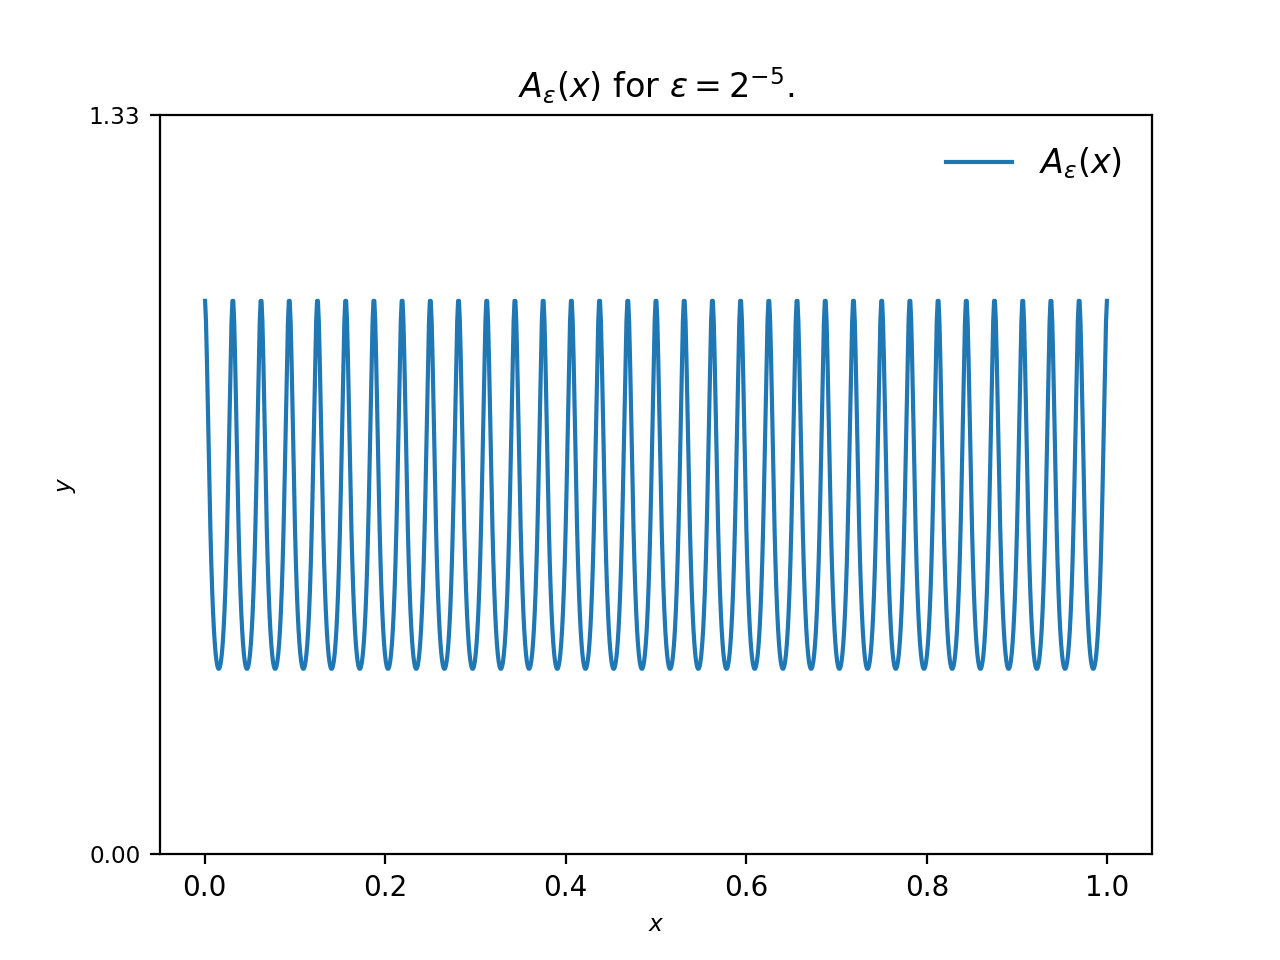

In [4]:
plt.figure('Coefficient')
plt.plot(xt,aFine, label='$A_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine)),fontsize="small")
plt.ylabel('$y$', fontsize="small")
plt.xlabel('$x$', fontsize="small")
plt.legend(frameon=False,fontsize="large")
plt.title('$A_{\epsilon}(x)$ for $\epsilon=2^{-5}$.')
plt.show()

## LOD approximations and error plot

Now, we simply apply the PG-LOD for each mesh size and compare each approximation.

<IPython.core.display.Javascript object>


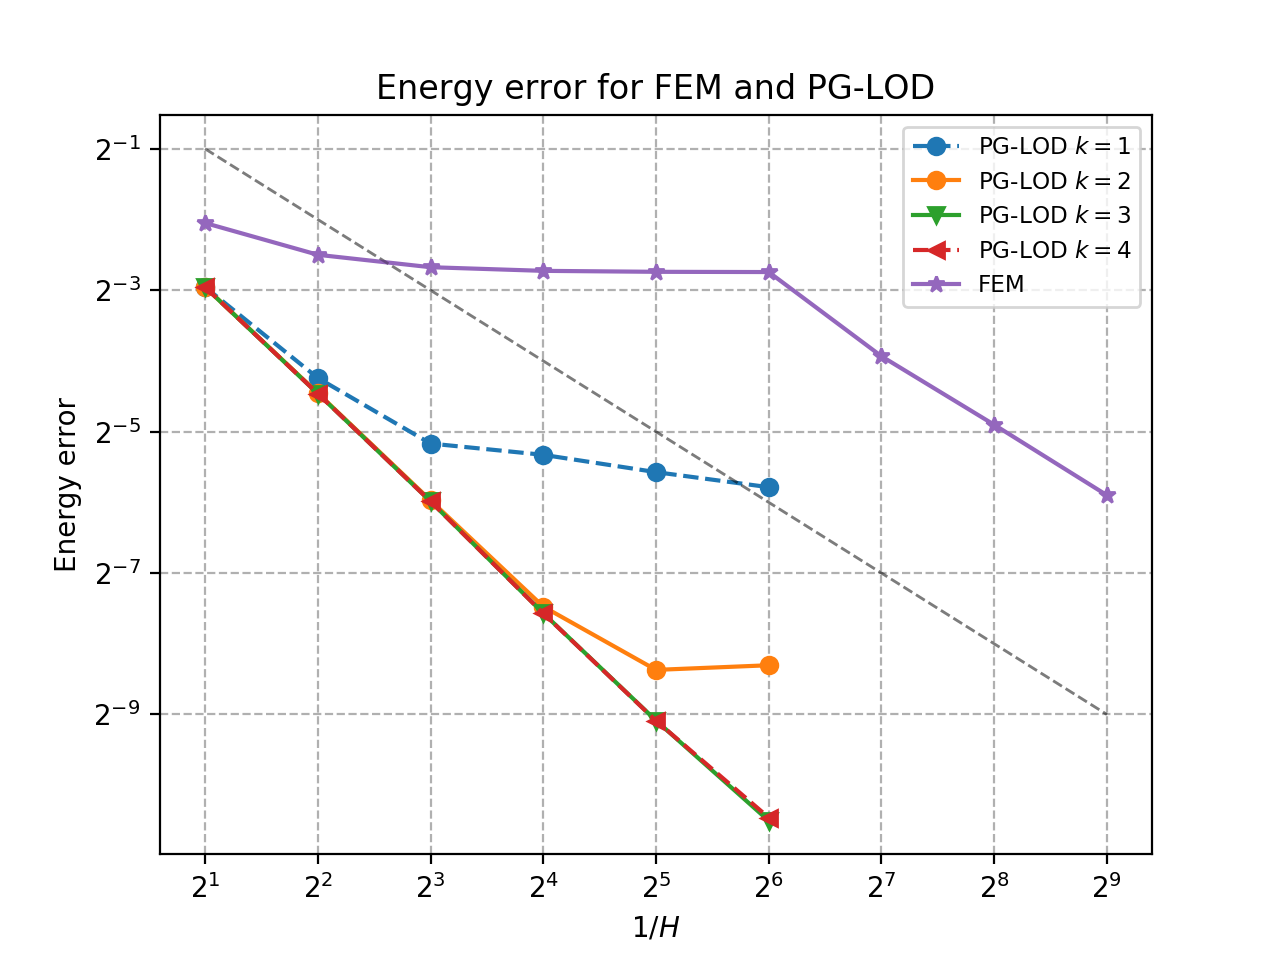

<IPython.core.display.Javascript object>


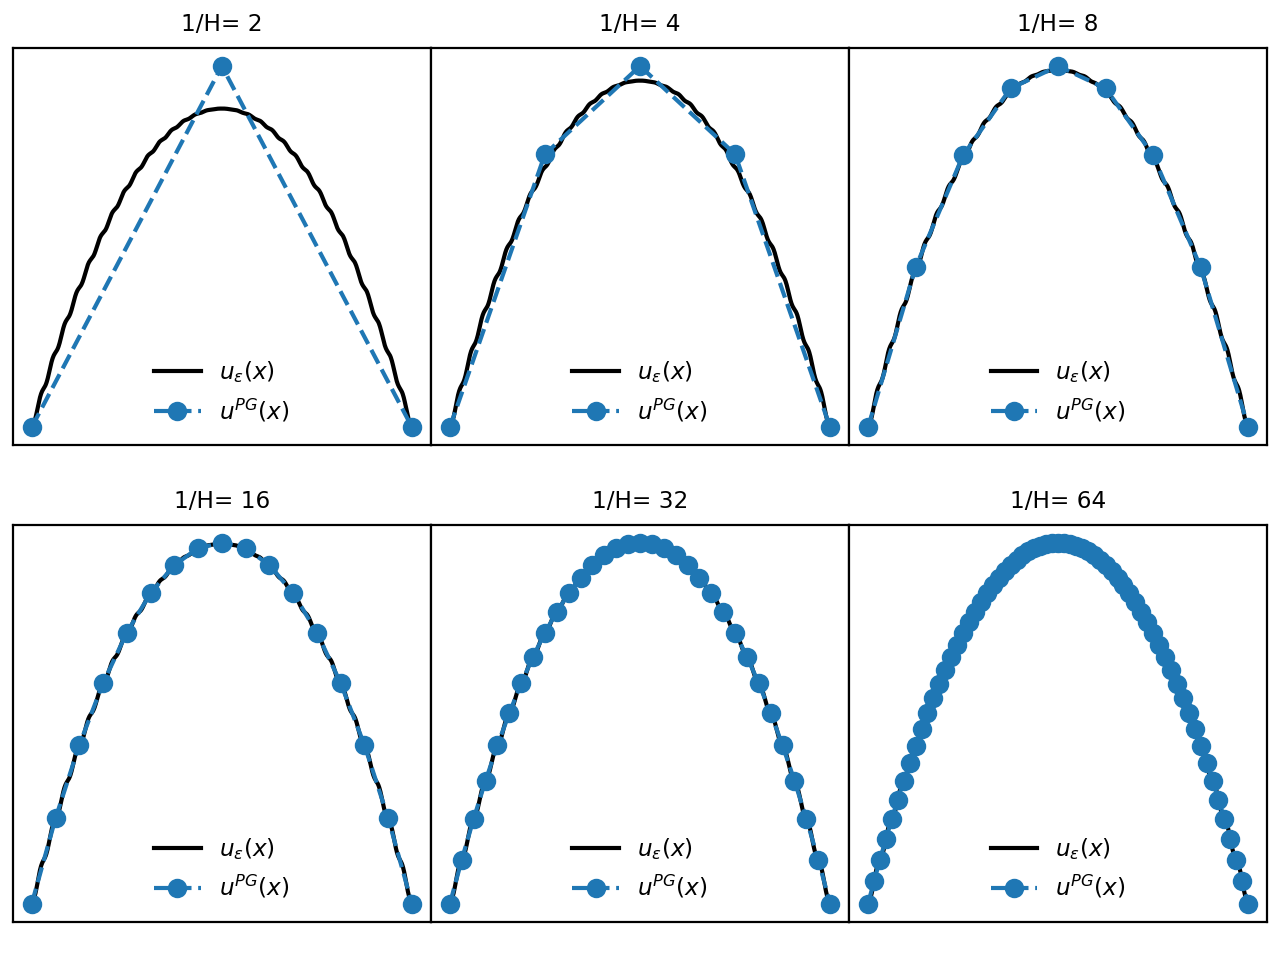

In [5]:
newErrorFine = []
x = []
y = []

for k in range(1,5):
    newErrorFine = []
    x = []
    y = []
    
    for N in NList:
        NWorldCoarse = np.array([N])
        boundaryConditions = np.array([[0, 0]])

        NCoarseElement = NFine/NWorldCoarse
        world = World(NWorldCoarse, NCoarseElement, boundaryConditions)
        AFine = fem.assemblePatchMatrix(NFine, world.ALocFine, aFine)
        # grid nodes
        xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
        NpCoarse = np.prod(NWorldCoarse+1)
    
        f = np.ones(NpCoarse)
        uCoarseFull, uLodCoarse = PGsolver(world,aFine,f,k)
    
        newErrorFine.append(np.sqrt(np.dot(uSol - uLodCoarse, AFine*(uSol - uLodCoarse))))
        x.append(N)
        y.append(1./N)
        if k == 4:
            if np.size(x)==1:
                plt.figure('LOD-Approximations')
                plt.subplots_adjust(left=0.01,bottom=0.04,right=0.99,top=0.95,wspace=0,hspace=0.2)
                plt.subplot(231)
            elif np.size(x)==2:
                plt.subplot(232)
            elif np.size(x)==3:
                plt.subplot(233)
            elif np.size(x)==4:
                plt.subplot(234)
            elif np.size(x)==5:
                plt.subplot(235)
            elif np.size(x)==6:
                plt.subplot(236)
            
            plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
            plt.plot(xpCoarse,uCoarseFull,'o--', label= '$u^{PG}(x)$')
            plt.title('1/H= ' + str(N),fontsize="small")
            plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
            plt.legend(frameon=False,fontsize="small")
            
    # extension of the plot
    x1 = []
    y = []
    for i in [2,4,8,16,32,64,128,256,512]:
        x1.append(i)
        y.append(1./i)
    
    plt.figure("Error comparison")
    if k == 1:
       plt.loglog(x,newErrorFine,'--o', basex=2, basey=2, label = 'PG-LOD $k=1$')
       #plt.loglog(x1,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
    if k == 2:
        plt.loglog(x,newErrorFine,'-o', basex=2, basey=2, label = 'PG-LOD $k=2$')
        #plt.loglog(x1,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
    if k == 3:
       plt.loglog(x,newErrorFine,'-v', basex=2, basey=2, label = 'PG-LOD $k=3$')
       plt.loglog(x1,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
    if k == 4:
        plt.loglog(x,newErrorFine,'--<', basex=2, basey=2, label = 'PG-LOD $k=4$')
    if k == 5:
        plt.loglog(x,newErrorFine,'--*', basex=2, basey=2, label = '$k=5$')
    if k == 6:
        plt.loglog(x,newErrorFine,'-o', basex=2, basey=2, label = '$k=6$')

    plt.grid(True,which="both",ls="--")
    plt.ylabel('Energy error')
    plt.xlabel('$1/H$')
    plt.title('Energy error for PG-LOD')
    plt.legend(fontsize="small") #Legende

plt.show()

## FEM-approximation for comparison

We use the exact same code that we have been using in previous computations. The data will be added to the plot above.

In [6]:
fine = 4096
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
NList = [2,4,8,16, 32, 64, 128, 256, 512]

pi = np.pi
xt = util.tCoordinates(NFine).flatten() #whats that mean values of the intervalls xp
xp = util.pCoordinates(NFine).flatten()

aFine = (2 - np.cos(2*pi*xt/epsilon))**(-1)

uSol  = 4*(xp - xp**2) - 4*epsilon*(1/(4*pi)*np.sin(2*pi*xp/epsilon) -
                                    1/(2*pi)*xp*np.sin(2*pi*xp/epsilon) -
                                    epsilon/(4*pi**2)*np.cos(2*pi*xp/epsilon) +
                                    epsilon/(4*pi**2))

uSol = uSol/4

newErrorFine = []
x = []
y = []

for N in NList:
    NWorldCoarse = np.array([N])
    boundaryConditions = np.array([[0, 0]])

    NCoarseElement = NFine/NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)
    AFine = fem.assemblePatchMatrix(NFine, world.ALocFine, aFine)
    
    #grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
    NpCoarse = np.prod(NWorldCoarse+1)
    f = np.ones(NpCoarse)
    uCoarseFull = femsolverCoarse.solveCoarse_fem(world, aFine, f, boundaryConditions)
    
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    uLodCoarse = basis*uCoarseFull
    newErrorFine.append(np.sqrt(np.dot(uSol - uLodCoarse, AFine*(uSol - uLodCoarse))))
    x.append(N)
    y.append(1./N)

plt.figure("Error comparison")
plt.loglog(x,newErrorFine,'*-', basex=2, basey=2, label= 'FEM')
plt.loglog(x,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
plt.grid(True,which="both",ls="--")
plt.title('Energy error for FEM and PG-LOD')
plt.legend(fontsize="small")
         
plt.show()